# Graph Analysis   
In this notebook we load the processed tau PET data for ADNI and A4, construct the partial correlation graphs and run the statistical analysis of graph level metrics.

## Imports

In [28]:
import marimo
import marimo as mo
import pandas as pd
import networkx as nx
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import altair as alt

from functools import partial

import seaborn as sns

plt.style.use("ggplot")

pd.set_option("display.max_columns", 100)

from sklearn.preprocessing import PowerTransformer
from sklearn.covariance import GraphicalLasso
from sklearn.pipeline import make_pipeline

## Utility functions
The core of the analysis goes like this:

1. Load a table with the regional tau SUVr for a given cohort
2. Estimate the precision matrix using `GraphicalLasso` from scikit-learn
3. Compute the partial correlation matrix from the precision matrix
4. Create a Networkx `Graph` from the partial correlation matrix and compute some graph metrics
5. Bootstrap: resample the table, and repeat steps 1-4 to estimate the confidence interval on the graph metrics.

The functions in this section roughly correspond to the steps just described.

In [29]:
def small_world_coeff(G, niter=1, nrand=10):
    """Compute the small world coefficient of a weighted graph G. Average over `nrand` samples of the randomized graph."""
    Crand = 0
    Lrand = 0

    for _ in range(nrand):
        G_rand = nx.random_reference(G, niter)

        Crand += nx.average_clustering(G_rand, weight="correlation")
        Lrand += nx.average_shortest_path_length(G_rand, weight="distance")

    C = nx.average_clustering(G, weight="correlation")
    L = nx.average_shortest_path_length(G, weight="distance")

    return (C / Crand) / (L / Lrand)


def unweighted_small_world_coeff(G, niter=1, nrand=10):
    """Compute the small world coefficient of a weighted graph. Average over `nrand` samples of the randomized graph."""
    Crand = 0
    Lrand = 0

    for _ in range(nrand):
        G_rand = nx.random_reference(G, niter)

        Crand += nx.average_clustering(G_rand)
        Lrand += nx.average_shortest_path_length(G_rand)

    C = nx.average_clustering(G)
    L = nx.average_shortest_path_length(G)

    return (C / Crand) / (L / Lrand)


def partial_correlation(precision):
    """Compute the partial correlation from a given precision matrix"""

    diag = precision.values.diagonal()

    # The - sign is correct, but the diagonal should have 1 instead of -1,
    # so we fill it explicitly with ones. The formula on wikipedia only applies
    # to off-diagonal elements
    partial_correl = -precision.copy() / np.sqrt(diag[:, None] * diag[None, :])

    np.fill_diagonal(partial_correl.values, 1)

    return partial_correl


def pcorr_to_distance(pcorr):
    """Compute the distance matrix associated to a given partial correlation
    matrix: disconnected nodes should stay disconnected, nodes with high
    correlation should be close to each other. We also drop connections associated with negative weights
    """

    # return (1 / np.abs(pcorr) - 1).replace({np.inf: 0, -np.inf: 0})

    # return (pcorr != 0) * (1 - np.abs(pcorr)) # same as Dyrba 2020, but removing connections set to 0 by lasso

    # As explained in the main text, we use arctanh to convert partial correlations into distances
    if pcorr <= 0:
        return 0
    else:
        return -np.arctanh(np.abs(pcorr) - 1)

    # return 1 - np.abs(pcorr) # this is what Dyrba 2020 uses, it makes fully connected graphs

    # return -np.log(np.abs(pcorr)).replace({np.inf: 0, -np.inf: 0, np.nan:0})


def compute_precision(data, params, return_covariance=False):
    """Takes a dataframe and computes the precision matrix via sklearn.covariance.GraphicalLasso. The data is first transformed via PowerTransformer to ensure normality.

    Arguments:
    data: dataframe
    params: dictionary of paramters passed to GraphicaLasso.
    return_covariance: if True, also return the covariance matrix. By default only return precision
    """

    glasso = make_pipeline(PowerTransformer(), GraphicalLasso(**params))

    glasso.fit(data)

    if return_covariance:
        labels = glasso.feature_names_in_
        return (
            pd.DataFrame(
                glasso.named_steps["graphicallasso"].precision_,
                index=labels,
                columns=labels,
            ),
            pd.DataFrame(
                glasso.named_steps["graphicallasso"].covariance_,
                index=labels,
                columns=labels,
            ),
        )
    else:
        # GraphicalLasso does not support working natively with dataframes
        # we have to restore the column names by hand
        labels = glasso.feature_names_in_
        return pd.DataFrame(
            glasso.named_steps["graphicallasso"].precision_,
            index=labels,
            columns=labels,
        )


def compute_partial_correlation(data, params):
    """Convenience function to compute the partial correlation matrix from data"""

    return partial_correlation(compute_precision(data, params))


def precision_to_graph(precision):
    """Convert the provided precision matrix into a networkx graph.

    Arguments:
    precision: dataframe, column names will become node labels
    allow_self_connections: bool, if False zero out the diagonal"""

    # Adjacency matrix
    adj = partial_correlation(precision)

    graph = nx.from_pandas_adjacency(adj)

    # we only included age to control for it, we remove it from the graph before computing graph metrics
    graph.remove_node("PTAGE")

    # remove self loops
    graph.remove_edges_from([(u, v) for u, v in graph.edges() if u == v])

    # rename weight to correlation
    nx.set_edge_attributes(
        graph,
        {
            (u, v): {"correlation": d["weight"]}
            for u, v, d in graph.edges(data=True)
        },
    )

    # convenience: absolute value of correlation
    nx.set_edge_attributes(
        graph,
        {
            (u, v): {"abs(correlation)": np.abs(d["weight"])}
            for u, v, d in graph.edges(data=True)
        },
    )

    # compute distances from partial correlations
    nx.set_edge_attributes(
        graph,
        name="distance",
        values={
            (u, v): pcorr_to_distance(weight)
            for u, v, weight in graph.edges(data="weight")
        },
    )

    return graph


def compute_metrics(graph, metrics):
    """Compute graph metrics for a networks graph.

    Arguments:
    graph: networkx graph
    metrics: dictionary of metric names and callables

    Returns:
    res: dictionary of metric names and metric values"""

    return {metric: metrics[metric](graph) for metric in metrics}


def data_to_metrics(data, params, metrics, randomize_graph=False):
    # Convenience function, wrapping all steps into one
    precision = compute_precision(data, params=params)

    if randomize_graph:
        graph = nx.random_reference(precision_to_graph(precision))
    else:
        graph = precision_to_graph(precision)

    return compute_metrics(graph, metrics)


def boostrap_graph_metrics(
    data, params, metrics, n_samples=8, randomize_graph=False
):
    """Resample the datframe data, generate graph and compute metrics. Returns a dataframe with the bootstrapped metrics"""

    bootstrap_samples = [
        data.sample(frac=1, replace=True) for _ in range(n_samples)
    ]

    with multiprocessing.Pool() as pool:
        res = pool.map(
            partial(
                data_to_metrics,
                params=params,
                metrics=metrics,
                randomize_graph=randomize_graph,
            ),
            bootstrap_samples,
        )

    return pd.DataFrame(res)


def bootstrap(data, func, n_samples=8):
    # Resample from data and apply fun to each sample
    # use this version for general functions rather than graph metrics

    bootstrap_samples = [
        data.sample(frac=1, replace=True) for _ in range(n_samples)
    ]

    with multiprocessing.Pool() as pool:
        res = pool.map(func, bootstrap_samples)

    return res

In [30]:
adni = pd.read_csv(
        "../../data_paths_and_cleaning/data/intermediate_data/adni/merged_adni_at_amy_pos_bi_harm.csv",
        dtype={"RID": str},
    )

# Normalize the adni values by cerebellum cortex values for better comparison to A4
adni = pd.concat(
        (
            adni[["RID", "CENTILOIDS"]],
            adni.drop(columns=["RID", "CENTILOIDS"]).div(
                adni["CEREBELLUM_CORTEX"], axis=0
            ),
        ),
        axis=1,
    ).drop(columns="CEREBELLUM_CORTEX")

a4 = pd.read_csv(
        "../../data_paths_and_cleaning/data/intermediate_data/a4/merged_a4_at_amy_pos_bi_harm.csv",
        dtype={"RID": str},
    ).drop(columns="CEREBELLUM_CORTEX")

# The demographics data is in a separate file from the regional tau, we will merge them later

demo_a4 = pd.read_csv(
        "../../data_paths_and_cleaning/data/demographic_csvs/A4/a4_filtered_demo.csv",
        dtype={"RID": str},
    )

demo_adni = pd.read_csv(
        "../../data_paths_and_cleaning/data/demographic_csvs/ADNI/adni_filtered_demo.csv",
        dtype={"RID": str},
    )

demog = pd.concat([demo_adni, demo_a4], keys=["ADNI", "A4"]).reset_index(
        level=0, names="Dataset"
    )


adni_with_demo = pd.merge(adni, demo_adni[["RID", "PTAGE"]], on="RID")
a4_with_demo = pd.merge(a4, demo_a4[["RID", "PTAGE"]], on="RID")

# For the next examples, we use the "high amyloid" group from ADNI
data = adni_with_demo[adni_with_demo["CENTILOIDS"] > 54].drop(
        columns=["RID", "CENTILOIDS"]
    )

## Example: estimate the partial correlation graph for one group

In [31]:
# parameters for the graphical lasso
_params = {
        "alpha": 0.15,
        "max_iter": 1000,
        "tol": 1e-3,
        "mode": "cd",
        "eps": 1e-12,
        "enet_tol": 1e-7,
    }

precision, covariance = compute_precision(
        data, _params, return_covariance=True
    )

pcorr = partial_correlation(precision)

graph = precision_to_graph(precision)

pcorr_tall = (
        pcorr[(pcorr < 1) & (pcorr != 0)]
        .unstack()
        .dropna()
        .reset_index()
        .rename(columns={0: "Partial Correlation"})
    )

_mask = np.triu(np.ones_like(pcorr, dtype=bool))
_pcorr_masked = pcorr.copy()
_pcorr_masked[_mask] = np.nan

_fig = px.imshow(
        _pcorr_masked.round(2),
        width=1000,
        height=1000,
        color_continuous_scale="PiYG",
        color_continuous_midpoint=0,
        title="Partial Correlation",
        text_auto=True,
    )

_fig.update_layout(
        {
            "plot_bgcolor": "white",
        }
    )

## Example: Visualize one graph
For graphical clarity we use the partial correlation squared as edge thickness, but all metrics are computed using the partial correlation directly.

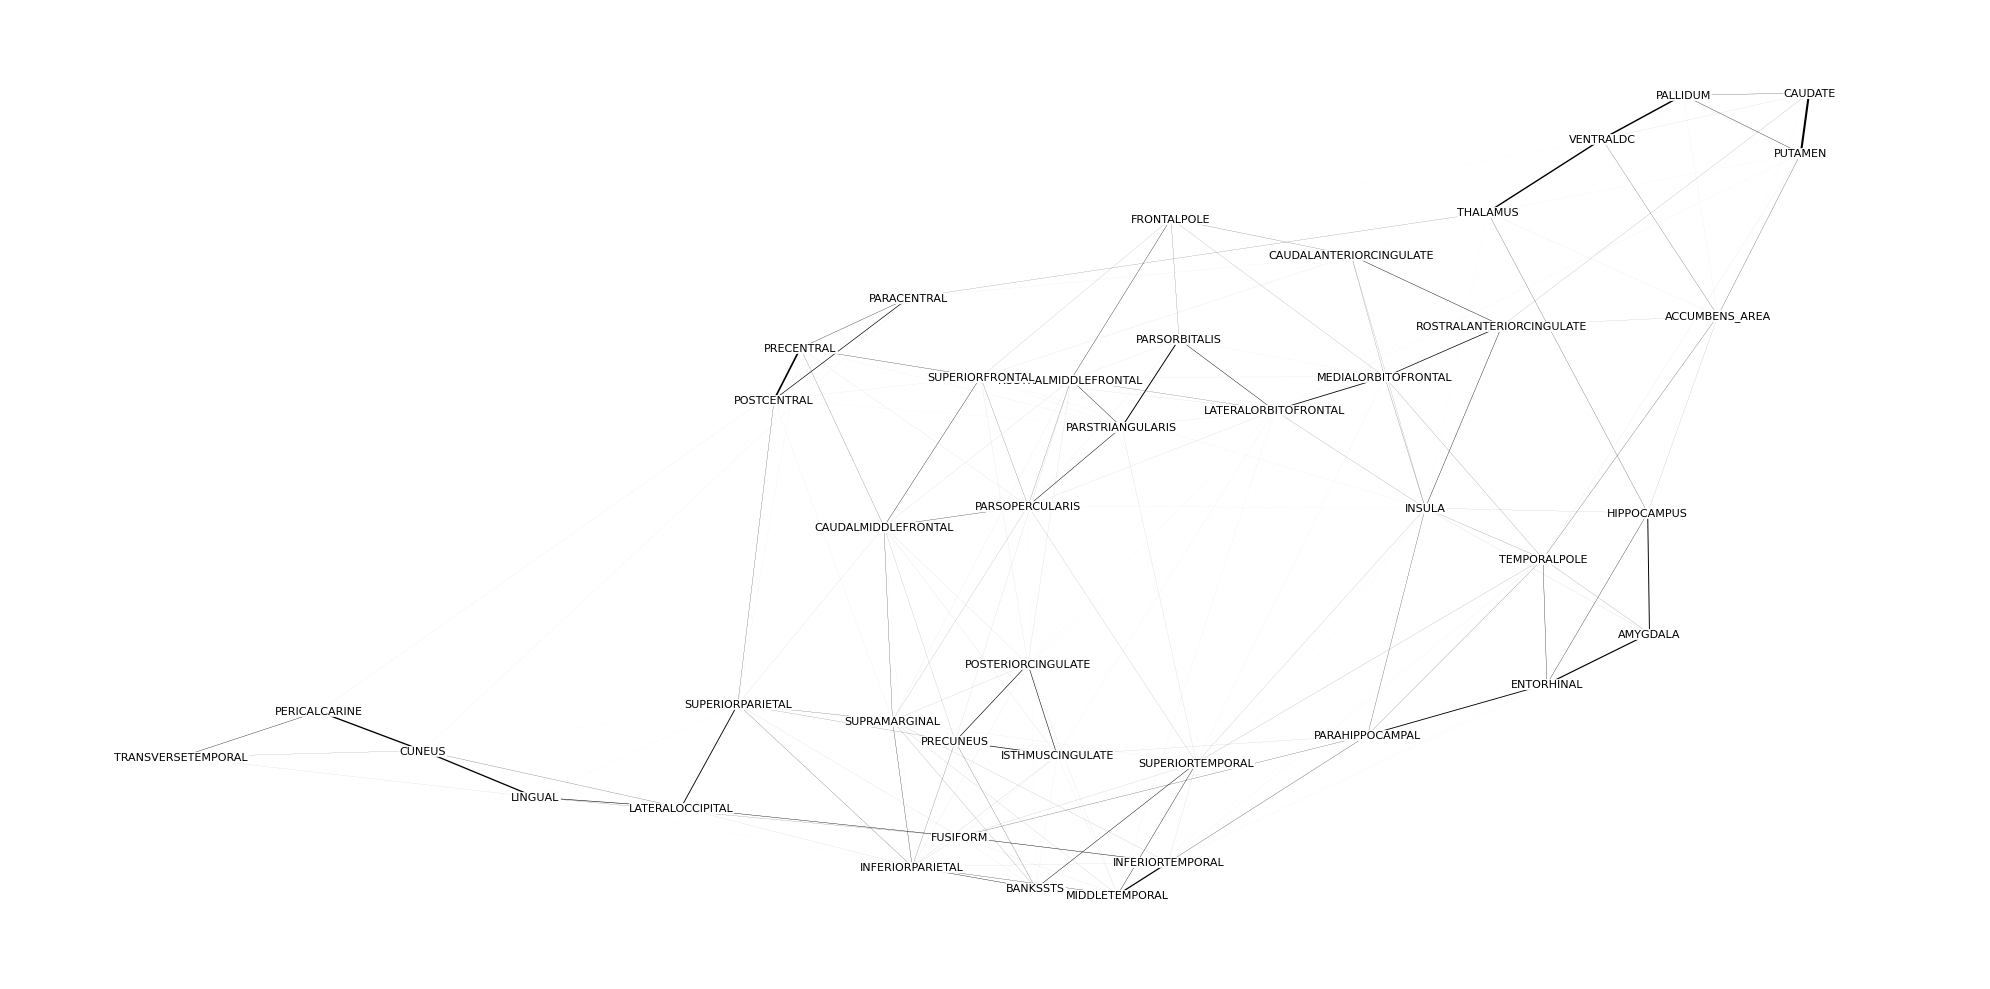

In [32]:
_edge_weights = [
        1.5 * (2.22 * graph[u][v]["abs(correlation)"]) ** 2
        for u, v in graph.edges()
    ]

_fig, _ax = plt.subplots(1, 1, figsize=(20, 10))

nx.set_edge_attributes(
        graph,
        {
            (u, v): {"plot_weight": 0.75 * (2.22 * d["abs(correlation)"]) ** 2}
            for u, v, d in graph.edges(data=True)
        },
    )

pos = nx.spectral_layout(graph, weight="distance")
pos = nx.spring_layout(graph, pos=pos, weight="plot_weight", iterations=100)

nx.draw_networkx_edges(graph, pos, width=_edge_weights, ax=_ax)

nx.draw_networkx_labels(
        graph,
        pos,
        ax=_ax,
        font_size=8,
        bbox=dict(facecolor="white", alpha=1, edgecolor="white", pad=0),
    )

    # Draw edge labels
    # edge_labels = nx.get_edge_attributes(graph, 'correlation')
    # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.axis("off")
_fig.tight_layout()

## Partial correlation sparsity with $L_1$ regularization
Here we recompute the precision matrix as a function of regularization strength $\alpha$. We end up selecting $\alpha = 0.15$ as the optimal value (by BIC).

Text(0, 0.5, 'Partial correlation matrix nonzero fraction')

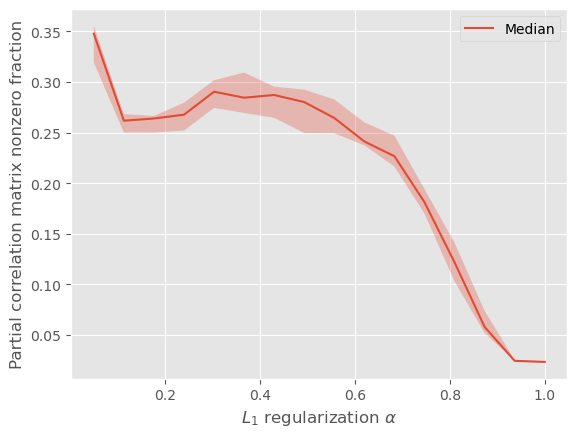

In [33]:
alphas = np.linspace(0.05, 1, 16)

_nz = []

_df = data

for alpha in alphas:
    _params = {
        "alpha": alpha,
        "max_iter": 1000,
        "tol": 1e-3,
        "mode": "cd",
        "eps": 1e-12,
        "enet_tol": 1e-7,
    }

    _fun = partial(compute_precision, params=_params)

    # this is a list, one per bootstrap samples
    _nonzero_counts = np.array(
        list(
            map(np.count_nonzero, bootstrap(_df, _fun, n_samples=8))
        )  # about 60s with n = 128
    )

    _nz.append(
        {
            "alpha": alpha,
            "Median": np.median(_nonzero_counts) / len(_df.columns) ** 2,
            "CI_low": np.quantile(_nonzero_counts, 0.025)
            / len(_df.columns) ** 2,
            "CI_high": np.quantile(_nonzero_counts, 0.975)
            / len(_df.columns) ** 2,
        }
    )

partial_corr_nz = pd.DataFrame(_nz)  # fraction of nonzero entries

partial_corr_nz.plot(x="alpha", y="Median")
plt.fill_between(
    partial_corr_nz.alpha,
    partial_corr_nz["CI_low"],
    partial_corr_nz["CI_high"],
    alpha=0.3,
)

plt.xlabel(r"$L_1$ regularization $\alpha$")
plt.ylabel("Partial correlation matrix nonzero fraction")

## Amyloid quantiles
We split both datasets in tertiles using the ADNI distribution as reference.

In [34]:
n_quantiles = 3

adni_quantile_labels, adni_amy_bins = pd.qcut(
    adni_with_demo["CENTILOIDS"], q=n_quantiles, retbins=True, labels=False
)

adni_amy_bins

a4[
    "CENTILOIDS"
].max()  # this should be less than the adni maximum, which it is

192.541

In [35]:
a4_quantile_labels = pd.cut(a4["CENTILOIDS"], adni_amy_bins, labels=False)


pd.concat(
    (a4_quantile_labels, adni_quantile_labels), keys=("A4", "ADNI")
).reset_index(level=0).rename(
    columns={"level_0": "Dataset", "CENTILOIDS": "Centiloid quantile"}
).value_counts().sort_index()

Dataset  Centiloid quantile
A4       0                     159
         1                     144
         2                      70
ADNI     0                     139
         1                     129
         2                     130
Name: count, dtype: int64

## Statistical analysis of graph metrics
For each cohort and amyloid tertile, we construct the partial correlation graph and estimate the corresponding graph metrics. The confidence intervals are estimated via boostrap.

In [36]:
metrics = {
    "Weighted Clustering Coefficient": partial(
        nx.average_clustering, weight="correlation"
    ),
    "Weighted Avg. Shortest Path Length": partial(
        nx.average_shortest_path_length, weight="distance"
    ),
    "Weighted Small World": partial(small_world_coeff, niter=1, nrand=10),
}

_params = {
    "alpha": 0.15,
    "max_iter": 1000,
    "tol": 1e-3,
    "mode": "cd",
    "eps": 1e-12,
    "enet_tol": 1e-7,
}

# in the paper we use 1000 bootstrap samples, this is just to showcase the method
_n_boot = 3

adni_boot_metrics_results = []
a4_boot_metrics_results = []

for quantile in range(n_quantiles):
    adni_boot_metrics_results.append(
        boostrap_graph_metrics(
            adni_with_demo[adni_quantile_labels == quantile]
            .drop(columns=["RID", "CENTILOIDS"])
            .dropna(),
            _params,
            metrics,
            n_samples=_n_boot,
            randomize_graph=False,
        )
    )

for quantile in range(n_quantiles):
    a4_boot_metrics_results.append(
        boostrap_graph_metrics(
            a4_with_demo[a4_quantile_labels == quantile]
            .drop(columns=["RID", "CENTILOIDS"])
            .dropna(),
            _params,
            metrics,
            n_samples=_n_boot,
            randomize_graph=False,
        )
    )

graph_metrics_by_quantile = (
    pd.concat(
        [
            pd.concat(adni_boot_metrics_results, keys=range(n_quantiles))
            .reset_index(level=0)
            .rename(columns={"level_0": "Centiloid Quantile"}),
            pd.concat(a4_boot_metrics_results, keys=range(n_quantiles))
            .reset_index(level=0)
            .rename(columns={"level_0": "Centiloid Quantile"}),
        ],
        keys=["ADNI", "A4"],
    )
    .reset_index(level=0)
    .rename(columns={"level_0": "Dataset"})
)

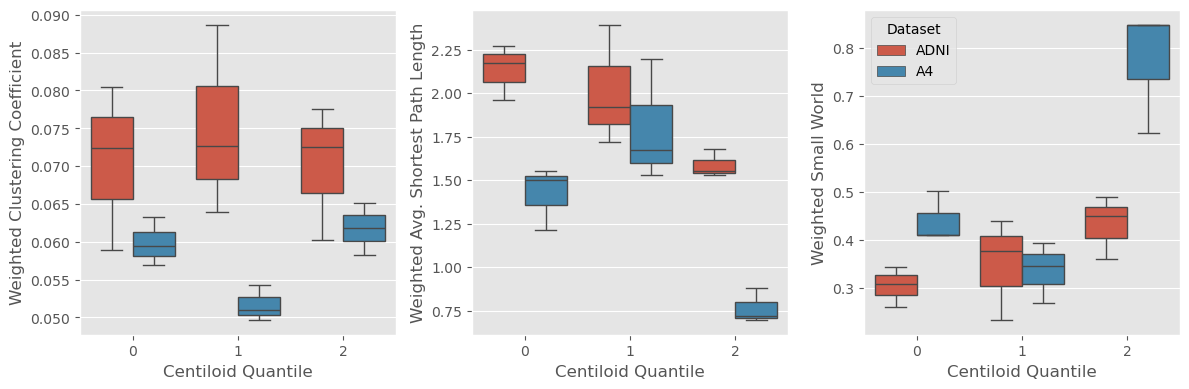

In [37]:
_fig, _ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

for _i, _metric in enumerate(metrics):
    sns.boxplot(
        graph_metrics_by_quantile,
        x="Centiloid Quantile",
        y=_metric,
        hue="Dataset",
        ax=_ax.flat[_i],
    )

_fig.tight_layout()
_ax[0].legend().set_visible(False)
_ax[1].legend().set_visible(False)